In [98]:
import numpy as np
import matplotlib.pyplot as plt 
import statistics

In [99]:
# to set
# k0s = np.linspace(np.pi,70*np.pi,200)

# for k0 in k0s:
k0 = 40 * np.pi

epsilon = 1E-3
J = 1000
lambdaa = 1

delta = 2 * epsilon**2 / lambdaa 
L = J * epsilon  # length of the domain

nx = 200  # number of spatial points
# nt = 35  # number of time steps

T = 0.5 * (L / k0) # total time, ~ L / k0 

dx = L / nx
dt = 2 * dx**2

nt = int(T / dt) 

x = np.linspace(0, L, nx)
    



In [100]:
# Domain parameters 
# delta = 2 * epsilon**2 / lambdaa 
# L = J * epsilon  # length of the domain

# nx = 200  # number of spatial points
# nt = 200  # number of time steps

# dx = L / nx
# dt = T / nt

# x = np.linspace(0, L, nx)
# print(delta)
# print(delta*nx)
# print(T)

In [101]:
# Gaussian wave packet
x0 = L / 4  # center of the wave packet
v0 = L / (2 * T) # 2*np.sqrt(V0) #(L / 2*T) / 2 #np.pi * 50 # 
# k0 = 50 * np.pi #v0 / 2 # wave number of the wave packet (p = hbar*k)
sigma = L / 20  # width of the wave packet
# epsilon = np.pi / (20 * k0)
N = (np.pi * sigma ** 2)**(-1/4) # Normalization 
delta = T / N
gaussian = np.exp(-0.5 * ((x - x0) / sigma) ** 2)
phase = np.exp(1j * k0 * x)
psi0 = (gaussian * phase) * N
norm = np.sum(psi0 * np.conj(psi0)) * dx # check in psi0 is normalized
# print(norm)


In [102]:
# Potential initial conditions 
# V0 = (0.5* k0**2)  # potential strength
V0 = 450 * np.pi**2
a = 0.032 #0.032  # width
V = np.zeros(nx)
V[int((nx - a * nx) / 2):int((nx + a * nx) / 2)] = V0 # indices for start and end of the well 

In [103]:
# Build coefficient matrix, a+
aplus = np.zeros((nx, nx),complex)
nu = 1j * dt / (4 * dx**2) # kinetic energy operator

for i in range(len(aplus) - 1): # off diagonal 
    aplus[i,i+1] = aplus[i+1,i] = -nu 

for i in range(len(aplus)): # diagonal
    aplus[i,i] = 1 + 2 * nu 

aplus_inv = np.linalg.inv(aplus)


In [104]:
# Build coefficient matrix, a-
aminus = np.zeros((nx, nx),complex)

for i in range(len(aminus)-1): # off diagonal 
    aminus[i,i+1] = aminus[i+1,i] = nu  

for i in range(len(aminus)): # diagonal
    aminus[i,i] = 1 - 2 * nu 

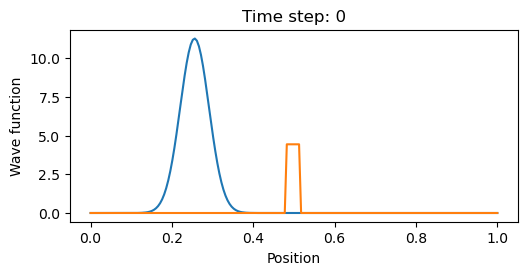

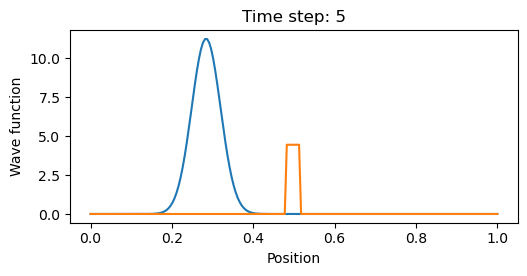

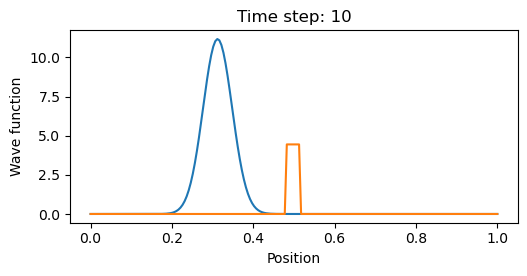

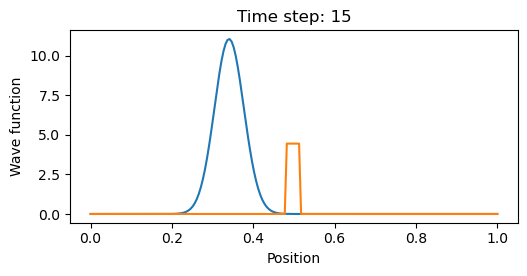

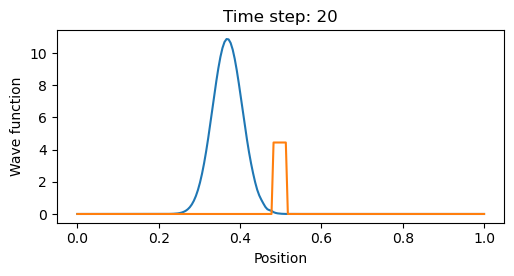

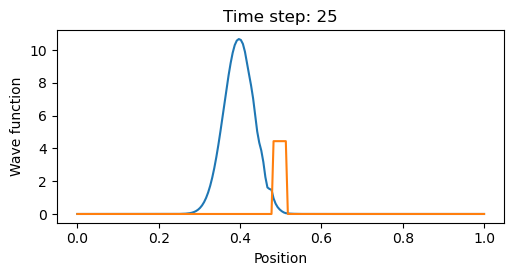

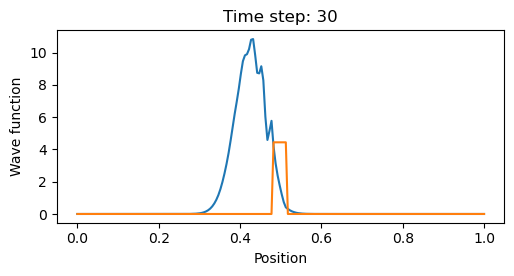

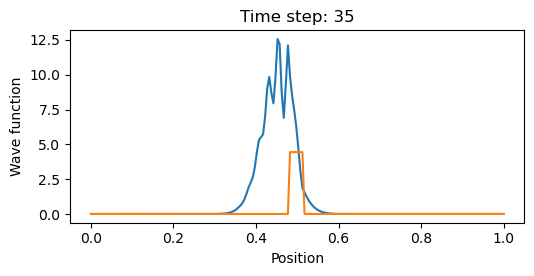

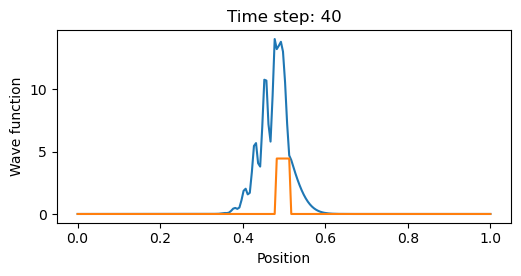

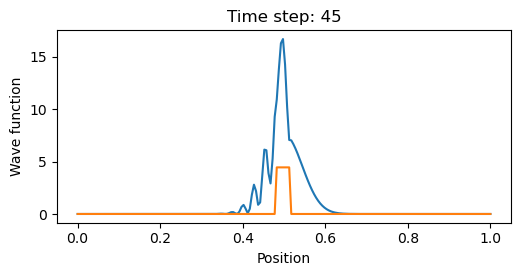

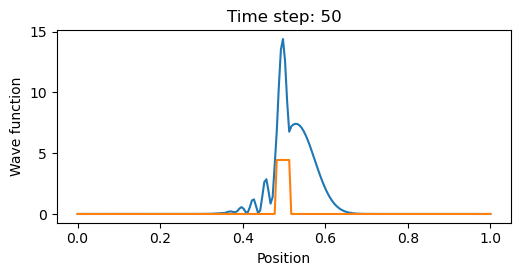

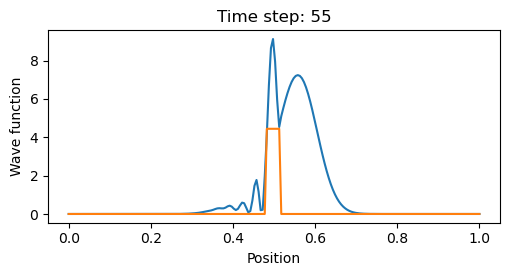

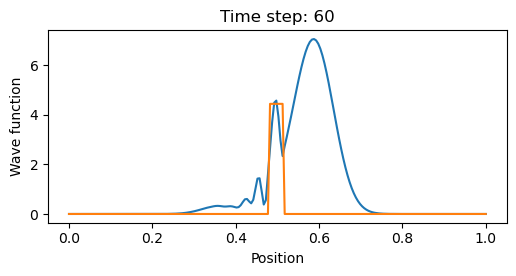

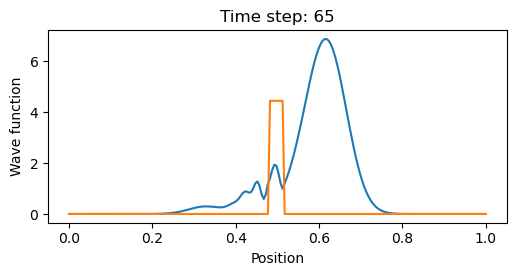

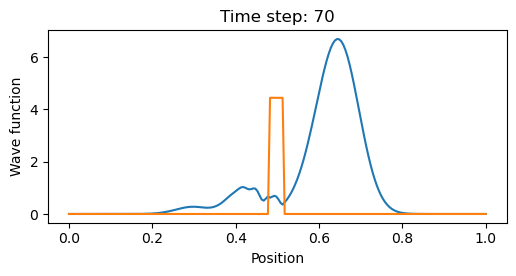

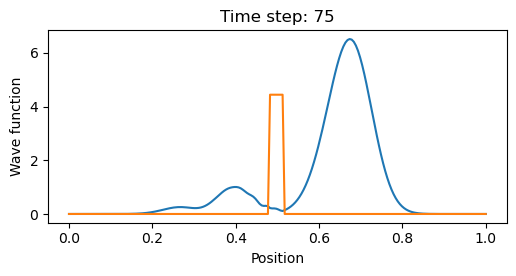

In [105]:
# Crank-Nicholson
for t in range(nt):
    f = np.exp(-1j * dt * V) * psi0
    psi = np.dot(aplus_inv, np.dot(aminus, f))
    psi0 = psi
    
    # plotting 
    if t % 5 == 0:
        # plt.plot(x, np.abs(psi))#, label=f'Time step: {t}')
        plt.figure(figsize=(10, 100))
        num_cols = 2  # Number of columns for subplots
        num_rows = (nt + num_cols - 1) // num_cols

        plt.subplot(num_rows, num_cols, t + 1)
        plt.plot(x, np.abs(psi)**2)
        plt.plot(x, V * epsilon)
        plt.title(f'Time step: {t}')
        plt.xlabel('Position')
        plt.ylabel('Wave function')
        plt.tight_layout()
    
plt.show()

# plt.plot(x, V, label='Potential (V)')
# plt.xlabel('Position')
# plt.ylabel('Wave function')
# plt.title('Gaussian wave packet scattering (TDSE w/ CN)')
# plt.legend()
# plt.show()
# print(rcoefs)


In [106]:
# Reflection and transmisison coefficients 
center = int(nx/2) # center of well

# Extract wavefunction segments for each region
reflected_wavefunction = psi[0: center] 
transmitted_wavefunction = psi[center: nx] 

# Calculate
# norm = np.sum(psi * np.conj(psi)) * dx
refl = np.sum(reflected_wavefunction * np.conj(reflected_wavefunction)) * dx 
trans = np.sum(transmitted_wavefunction * np.conj(transmitted_wavefunction)) * dx 

# Save
rcoefs = []
rcoefs.append(np.real(refl))
tcoefs = [] 
tcoefs.append(np.real(trans))
k0s = []
k0s.append(k0)

print(f"Reflection coefficient (R): {refl}")
print(f"Transmission coefficient (T): {trans}")
print(refl + trans)
print(norm)
print(rcoefs)
print(tcoefs)
print(k0)

Reflection coefficient (R): (0.13418392574555862+0j)
Transmission coefficient (T): (0.8608160742539681+0j)
(0.9949999999995267+0j)
(0.9949999999995622+0j)
[0.13418392574555862]
[0.8608160742539681]
125.66370614359172


In [107]:
# # Calc R and T for time steps 
# rcoefs = []
# tcoefs = []

# for t in range(nt):
#     reflected_wavefunction = psi[0: center]
#     transmitted_wavefunction = psi[center: nx]
#     norm = np.sum(psi * np.conj(psi)) * dx

#     rcoef = np.sum(reflected_wavefunction * np.conj(reflected_wavefunction)) * dx / norm
#     rcoefs.append(rcoef)
#     tcoef = np.sum(transmitted_wavefunction * np.conj(transmitted_wavefunction)) * dx / norm
#     tcoefs.append(tcoef)



# print(rcoefs)


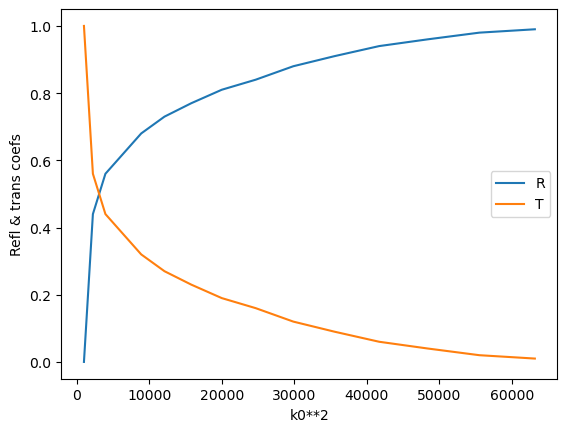

In [108]:
# Ramsauer-Townsend
k0s = [10, 15, 20, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80] * np.array(np.pi)
rs = [0, 0.44, 0.56, 0.68, 0.73, 0.77, 0.81, 0.84, 0.88, 0.91, 0.94, 0.96, 0.98, 0.99]
ts = [1, 0.56, 0.44, 0.32, 0.27, 0.23, 0.19, 0.16, 0.12, 0.09, 0.06, 0.04, 0.02, 0.01]
plt.plot(k0s**2, rs, label= 'R')
plt.plot(k0s**2, ts, label = 'T')
plt.xlabel("k0**2")
plt.ylabel('Refl & trans coefs')
plt.title('')
plt.legend()
plt.show()
# print([k0] * nx)

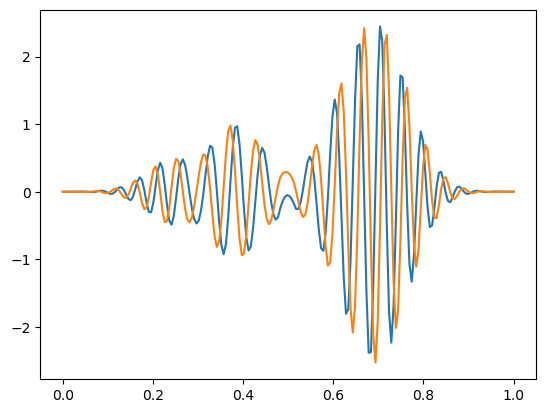

In [109]:
f = np.exp(-1j * dt * V) * psi0
# plt.plot(x, V)
plt.plot(x, f.real)
plt.plot(x, f.imag)
plt.show()